# **Day-ahead Banknifty/Nifty Forecasting**

#### Input - 15 mins candle data
#### Output - Forcast of 1 day of 15 mins close price  

Special Notes:
 - Don't open CSV file and change dateformat, it will change the format entirely and cause problem in code
 - Output of Model changed if we dont delete NaN values (I saw that when comparing jupyter file with normal python file matching)

In [1]:
plot_show_or_not = False

## Define stock for which ML model needs to be prepared

In [2]:
# Get data from Python file--------------
import json

# Load the arguments
with open('arguments.json', 'r') as fid:
    arguments = json.load(fid)

stock = arguments['ticker']

stock = "BANKNIFTY"
print(stock)

BANKNIFTY


In [3]:
from datetime import datetime, timedelta
from pandas.tseries.offsets import DateOffset
import math
import pickle # Saving the final model
import time
import datetime as dt

##############
# Dependencies
##############
import json
import requests
import numpy as np
import pandas as pd
import os, time, math
from datetime import *
os.environ['TZ'] = 'Asia/Calcutta'
from sqlalchemy import create_engine
from scipy.signal import savgol_filter
pd.options.mode.chained_assignment = None





##################
# Visualizations
#################
import seaborn as sns
#import plotly.offline
#import cufflinks as cf
import matplotlib.pyplot as plt
from matplotlib import rc, rcParams



##################
# Display Changes
##################
# cf.go_offline()
%matplotlib inline
rc('axes', linewidth=2)
rc('font', weight='bold')
sns.set_style('whitegrid')
#pd.set_option('max_rows',2000)
#pd.set_option('max_columns',255) 
rcParams['figure.figsize'] = 15,5
#cf.set_config_file(offline=False, world_readable=True)


##############
# Modeling
##############
# import xgboost as xgb
# from xgboost import plot_importance
from sklearn import preprocessing, svm
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, RobustScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [4]:
# ##################
# # Display Changes
# ##################
# from matplotlib import rc, rcParams
# pd.options.mode.chained_assignment = None
# # cf.go_offline()
# %matplotlib inline
# rc('axes', linewidth=2)
# #rc('font', weight='bold')

# #pd.set_option('max_rows', 1000)
# pd.set_option('display.max_rows', None)
# pd.set_option('max_columns', 255)
# # Useful line of code to set the display option so we could see all the columns in pd dataframe
# #pd.set_option('display.max_columns', None)

# #rcParams['figure.figsize'] = 8,3
# # cf.set_config_file(offline=False, world_readable=True)

# rc('xtick', labelsize=9) 
# rc('ytick', labelsize=9)
# #rc('axes', linewidth=2)
# rc('axes', titlesize=10)


# # Matplot Theme setting
# from matplotlib import cycler
# colors = cycler('color',
#                 ['#EE6666', '#3388BB', '#9988DD',
#                  '#EECC55', '#88BB44', '#FFBBBB'])
# rc('axes', facecolor='#E6E6E6', edgecolor='none', axisbelow=True, grid=True, prop_cycle=colors)
# rc('grid', color='w', linestyle='solid')
# rc('xtick', direction='out', color='black')
# rc('ytick', direction='out', color='black')
# rc('patch', edgecolor='#E6E6E6')
# rc('lines', linewidth=1)

In [5]:
# Seaborn
rc = {
    "axes.facecolor": "#FAEEE9",
    "figure.facecolor": "#FAEEE9",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7",
    "font.family": "calibri",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.9
}
sns.set(rc=rc)
sns.set_context("notebook", font_scale=0.9, rc={"lines.linewidth": 1})


#sns.set_style('whitegrid')

In [6]:
datetime.now()

datetime.datetime(2024, 2, 1, 11, 13, 49, 806416)

## Prevent plot from showing

In [7]:
#plt.ioff()

## Analysis

In [8]:
# I have make the function for Doing quick basic analysis as per given DataFrame

def analysis(df):
    
    print('#############################################################')
    print(f'Shape of DF = {df.shape}\n')
    print('--------------------------------------------------')
    print(f'First 5 rows are as following \n {df.head()} \n')
    print('--------------------------------------------------')
    print(f'Basic info as following \n {df.info()} \n')
    print('--------------------------------------------------')
  
    if 'datetime' in df.columns:
        print(f"\n We have data from {pd.to_datetime(df['datetime']).min()}")
        print(f" We have data till {pd.to_datetime(df['datetime']).max()}")
    print('--------------------------------------------------')
    print(f'\n Basic description as following \n')
    print(df.describe())
    print('--------------------------------------------------')
    print(f'\n Missing values are as following \n')
    print(df.isnull().sum())
    print('##############################################################')

In [9]:
# from google.colab import drive
# drive.mount('/content/drive')
# folder_path = '/content/drive/MyDrive/Climate_Connect/IEX/01_Data_Tuesday_Forecast'

In [10]:
# As its difficult to upload files again and again, so I change code to access drive files. 

#df = pd.read_parquet('./Data/historical_load_data.parquet')
#df = pd.read_excel(f'{folder_path}/DAM_multivariate_data.xlsx')


df = pd.read_csv(f'01_Data\data_{stock}.csv')
df.head(7)

,datetime,open,high,low,close,volume,date
0,2018-01-01 09:15:00,25565.75,25588.00,25496.55,25561.50,0,NaN
1,2018-01-01 10:15:00,25563.65,25573.25,25541.40,25552.65,0,NaN
2,2018-01-01 11:15:00,25555.00,25566.30,25515.30,25524.60,0,NaN
3,2018-01-01 12:15:00,25523.90,25528.95,25504.85,25508.40,0,NaN
4,2018-01-01 13:15:00,25507.20,25533.75,25495.00,25531.85,0,NaN
5,2018-01-01 14:15:00,25532.10,25557.50,25292.70,25324.65,0,NaN
6,2018-01-01 15:15:00,25323.95,25329.80,25271.55,25318.10,0,NaN


In [11]:
df.tail(7)

,datetime,open,high,low,close,volume,date
10509,2024-01-31 10:15:00,45818.20,46127.75,45760.70,46056.25,0,NaN
10510,2024-01-31 11:15:00,46054.15,46177.85,46022.30,46046.35,0,NaN
10511,2024-01-31 12:15:00,46047.05,46082.20,45872.00,46015.45,0,NaN
10512,2024-01-31 13:15:00,46014.45,46084.35,45935.65,46041.30,0,NaN
10513,2024-01-31 14:15:00,46041.70,46137.80,45922.35,45990.60,0,NaN
10514,2024-01-31 15:15:00,45989.35,46025.00,45943.55,45974.00,0,NaN
10515,2024-02-01 09:15:00,46164.90,46173.30,45708.05,45855.30,0,NaN


### Only retain "Close" & "Volume"

In [12]:
drop_col = ['open', 'high', 'low', 'volume', 'date']
df = df.drop(drop_col, axis=1)
df.head()

,datetime,close
0,2018-01-01 09:15:00,25561.50
1,2018-01-01 10:15:00,25552.65
2,2018-01-01 11:15:00,25524.60
3,2018-01-01 12:15:00,25508.40
4,2018-01-01 13:15:00,25531.85


In [13]:
max_year = pd.to_datetime(df['datetime']).max().year
min_year = pd.to_datetime(df['datetime']).min().year


print(f"\n We have data from {pd.to_datetime(df['datetime']).min()}")
print(f" We have data till {pd.to_datetime(df['datetime']).max()}")


 We have data from 2018-01-01 09:15:00
 We have data till 2024-02-01 09:15:00


In [14]:
last_entry_df = pd.to_datetime(df['datetime']).max()
print(last_entry_df)

2024-02-01 09:15:00


In [15]:
#df.tz_convert('UTC')
#d = pd.to_datetime(df['datetime'],format='%m-%d-%Y %H:%M:%S').min()
#d.month

In [16]:
# DataType convertion

df['datetime'] = pd.to_datetime(df['datetime'])
df['date'] = df['datetime'].dt.date

In [17]:
# Missing Data checking

df = df.sort_values('datetime').copy()
print('Missing Value summary')
print(f'{df.isnull().sum()} \n')

# Missing and Duplicate values checking
print('If there is any missing and duplicate values')
df.date.value_counts()[df.date.value_counts() != 7] # 7 As we have one hour data

# %age missing values
# df.isnull().sum()/df.shape[0]*100

Missing Value summary
datetime    0
close       0
date        0
dtype: int64 

If there is any missing and duplicate values


2021-02-24    3
2020-11-14    3
2019-10-27    3
2021-11-04    2
2018-11-07    2
2023-11-12    1
2022-10-24    1
2024-02-01    1
Name: date, dtype: int64

In [18]:
# Drop the Duplicated values
df.drop_duplicates(['datetime'], keep='first', inplace=True)

In [19]:
## Plot as per original data on daily basis
def original_plot(df, feature):
    #plt.figure(figsize=(12,5))
    #df.set_index('datetime').resample('D')[feature].mean().plot()
    df.set_index('datetime')[feature].plot()
    plt.xlim([df.datetime.min(), df.datetime.max()])
    plt.ylabel(feature)
    plt.title(f"{feature} Data on daily basis")
    plt.tight_layout()

In [20]:
if plot_show_or_not == True:
    original_plot(df, 'close')

### Holiday Data - Step not performed as holiday data is very less

## DataFrame Preperation

In [21]:
print(pd.to_datetime(df['datetime']).dt.date.min())
print(pd.to_datetime(df['datetime']).dt.date.max())
print(pd.to_datetime(df['datetime']).dt.date.max() + timedelta(days=1)) # today + 1 day(forecast date)

2018-01-01
2024-02-01
2024-02-02


In [22]:
"""
# NO NEED to do as below due to the following:
 - We have many muhuraat days
 - We have holidays
 
"""


# # Prepare FInal Daraframe to avoid any missing time block

# #start_date = '2020-07-01'
# #end_date = '2023-02-17' # today + 1 day(forecast date)

# start_date = pd.to_datetime(df['datetime']).dt.date.min() # Data is available from 
# end_date = pd.to_datetime(df['datetime']).dt.date.max() + timedelta(days=1) # Data available till



# z = pd.DataFrame(pd.date_range(start=start_date, end=end_date, freq='1H',closed='left'), columns=['datetime']) #inclusive in the newer version
# df = pd.merge(z, df, on='datetime', how='left').copy()

# df['date'] = df['datetime'].dt.date
# # Make column for Time Block here 
# df['tb'] = df['datetime'].apply(lambda x : ((x.hour*60 + x.minute)//60+1))

# print(df.shape)
# print(df.tail())
# print(f"\n Close data is missing for {df.close.isna().sum()} records")

'\n# NO NEED to do as below due to the following:\n - We have many muhuraat days\n - We have holidays\n \n'

In [23]:
# %age missing values
df.isnull().sum()/df.shape[0]*100

datetime    0.0
close       0.0
date        0.0
dtype: float64

In [24]:
df.columns

Index(['datetime', 'close', 'date'], dtype='object')

In [25]:
'''
Missing Values treatment
'''

## Interpolation Technique
df['close'] = df['close'].interpolate()

df.isnull().sum()

datetime    0
close       0
date        0
dtype: int64

In [26]:
# %age missing values
df.isnull().sum()/df.shape[0]*100

datetime    0.0
close       0.0
date        0.0
dtype: float64

## EDA

In [27]:
if plot_show_or_not == True:
    for x in [x for x in range(min_year, max_year+1)]:
        df[df.datetime.dt.year==x].set_index('datetime').resample('D')['close'].mean().plot(label=x, figsize=(12,7))
        plt.ylim([10, df.close.quantile(0.99)])
        plt.legend(loc="lower left")

In [28]:
# To check if mcp_dam is normally distributed or not
import scipy.stats as stat
import pylab

if plot_show_or_not == True:
    
    plt.subplot(1,2,1)
    sns.histplot(data=df,x='close', alpha=0.5, bins=20)

    plt.subplot(1,2,2)
    stat.probplot(df['close'],dist='norm',plot=pylab)
    plt.show()

As curve is not following staright line, so close is not normally distributed.

In [29]:
## Checking zero or -ve mcp_dam values
df.loc[df['close']<=0, :]

,datetime,close,date


So we have few zero values, we need to replace all with NaN and later will interpolate to get values

In [30]:
df.loc[df['close']==0, 'close'] = np.nan
## Interpolation Technique
df['close'] = df['close'].interpolate()
df.isnull().sum()

datetime    0
close       0
date        0
dtype: int64

## Feature Engineering

In [31]:
def gen_datetime_features(data):
    
    try:
        #Adding time based features
        print('Adding time based features...')
        data['date'] = data.datetime.dt.date   
        data['hour'] = data.datetime.dt.hour + 1      # Categorical 24
        data['dom' ] = data.datetime.dt.day       # Categorical 30/31    
        data['month'] = data.datetime.dt.month        # Categorical 12
        data['year']=data.datetime.dt.year            # Categorical 12
        data['dow'] = data.datetime.dt.dayofweek      # Categorical 7
        data['doy'] = data.datetime.dt.dayofyear      # Categorical 365/366
        data['woy'] = data.datetime.dt.week # Categorical 52
    
        data['week_number'] = data['datetime'].apply(lambda time: time.strftime("%V"))
        # Above is Object DataType, so change to int
        data['week_number'] = data['week_number'].astype('int')
    
        # Friday
        data.loc[data.dow == 4, 'friday'] = 1
        data.loc[data.dow != 4, 'friday'] = 0   
    
    
        # Covid
        data.loc[data.year.isin([2020,2021,2022]),'covid'] = 1
        data['covid'] = data['covid'].replace(np.nan, 0)
        # Covid 1st wave
        data.loc[(data.year==2020)&(data.month.isin([3,4,5,6,7,8,9])),'covid_first_wave'] = 1
        data['covid_first_wave'] = data['covid_first_wave'].replace(np.nan, 0)
        # Covid 2nd wave
        data.loc[(data.year==2021)&(data.month.isin([3,4,5,6])),'covid_second_wave'] = 1
        data['covid_second_wave'] = data['covid_second_wave'].replace(np.nan, 0)

        print(data.columns)
        return data
    except Exception as e:
        print("Error in adding time based features")



# Creating Cyclic Time Indicators

def cyclic(data,feature):
    import math
    data['norm'] = 2 * math.pi * data[f"{feature}"] / data[f"{feature}"].max()
    data[f"cos_{feature}"] = np.cos(data["norm"])
    data[f"sin_{feature}"] = np.sin(data["norm"])
    data.drop('norm',1,inplace=True)
    return data


def gen_cyclic_features(data):
    
    try:
        print('Adding Cyclic Time Indicators........')
        data = cyclic(data,'hour')
        data = cyclic(data,'dow')
        data = cyclic(data,'doy')
        return data
    except Exception as e:
        print("Error in adding Cyclic Time Indicators")





def gen_lag_features(data):
    try:
        # Encoding TS variables
        print('Adding TB Lag features...')
        variable_used = 'close'


        # As we have large data, so better we should drop NaN values
        data['lag1h'] = data[variable_used].shift(1*4)
        data['lag2h'] = data[variable_used].shift(2*4)
        data['lag4h'] = data[variable_used].shift(4*4)
        data['lag6h'] = data[variable_used].shift(6*4)
        data['lag12h'] = data[variable_used].shift(12*4)
        data['lag1d'] = data[variable_used].shift(24*4)
        data['lag2d'] = data[variable_used].shift(2*24*4)
        data['lag3d'] = data[variable_used].shift(3*24*4)
        data['lag4d'] = data[variable_used].shift(4*24*4)
        data['lag5d'] = data[variable_used].shift(5*24*4)
        data['lag6d'] = data[variable_used].shift(6*24*4)
        data['lag7d'] = data[variable_used].shift(7*24*4)
    


    # Exponential Moving Averages
        data['mcp_dam_ewm1h'] = data[variable_used].ewm(span = 1*4).mean()
        data['mcp_dam_ewm2h'] = data[variable_used].ewm(span = 2*4).mean()
        data['mcp_dam_ewm3h'] = data[variable_used].ewm(span = 3*4).mean()
        data['mcp_dam_ewm4h'] = data[variable_used].ewm(span = 4*4).mean()
        data['mcp_dam_ewm6h'] = data[variable_used].ewm(span = 6*4).mean()
        data['mcp_dam_ewm8h'] = data[variable_used].ewm(span = 8*4).mean()
        data['mcp_dam_ewm12h'] = data[variable_used].ewm(span = 12*4).mean()
        data['mcp_dam_ewm24h'] = data[variable_used].ewm(span = 24*4).mean()
    
    
    
    
    # Moving Averages
        #for x in [4,8,12,24,48,96]:
        for x in range(1,30):
            data[f'close_rolling_mean_{x}'] = data[variable_used].rolling(x,1).mean().shift()
            data[f'close_rolling_max_{x}'] = data[variable_used].rolling(x,1).max().shift()
            data[f'close_rolling_min_{x}'] = data[variable_used].rolling(x,1).min().shift()

    # Differences
    # As per analysis these features has least importance , so we will not use 
        data['ramp1'] = data[variable_used] - data[variable_used].shift(1)
        data['ramp2'] = data[variable_used].shift(1) - data[variable_used].shift(2)
        data['ramp3'] = data[variable_used].shift(2) - data[variable_used].shift(3)
        data['ramp4'] = data[variable_used].shift(3) - data[variable_used].shift(4)
    

#     # Taking Last 7 day same TB Mean, These features are super important
#     data['avg_mcp_dam_7d'] = (data['mcp_dam'] + data['mcp_dam'].shift(96) + data['mcp_dam'].shift(2*96) + data['mcp_dam'].shift(3*96)) + data['mcp_dam'].shift(4*96) + data['mcp_dam'].shift(5*96) + data['mcp_dam'].shift(6*96) / 7
#     data['avg_mcp_dam_9d'] = (data['avg_mcp_dam_7d']*7 + data['mcp_dam'].shift(7*96) + data['mcp_dam'].shift(8*96))/9
#     data['avg_mcp_dam_11d'] = (data['avg_mcp_dam_9d']*9 + data['mcp_dam'].shift(9*96) + data['mcp_dam'].shift(10*96))/11
#     data['avg_mcp_dam_13d'] = (data['avg_mcp_dam_11d']*11 + data['mcp_dam'].shift(11*96) + data['mcp_dam'].shift(12*96))/13
#     data['avg_mcp_dam_15d'] = (data['avg_mcp_dam_13d']*13 + data['mcp_dam'].shift(13*96) + data['mcp_dam'].shift(14*96))/15
#     data['avg_mcp_dam_17d'] = (data['avg_mcp_dam_15d']*15 + data['mcp_dam'].shift(15*96) + data['mcp_dam'].shift(16*96))/17
#     data['avg_mcp_dam_19d'] = (data['avg_mcp_dam_17d']*17 + data['mcp_dam'].shift(17*96) + data['mcp_dam'].shift(18*96))/19
#     data['avg_mcp_dam_21d'] = (data['avg_mcp_dam_19d']*19 + data['mcp_dam'].shift(19*96) + data['mcp_dam'].shift(20*96))/21
    
    
    
    
        print(data.columns)
        return data
    except Exception as e:
        print(f"Error in adding Lag based features--{e}")


In [32]:
df = gen_datetime_features(df).copy()

Adding time based features...
Index(['datetime', 'close', 'date', 'hour', 'dom', 'month', 'year', 'dow',
       'doy', 'woy', 'week_number', 'friday', 'covid', 'covid_first_wave',
       'covid_second_wave'],
      dtype='object')


## Outliers checking - Not Done

## Check the Trend, Seasonality & Residual

In [33]:
if plot_show_or_not == True:
    
    # Let's try decomposing the load data
    from statsmodels.tsa.seasonal import seasonal_decompose
    import matplotlib as mpl
    from pylab import rcParams
    # Extra settings
    seed = 42
    np.random.seed(seed)
    #plt.style.use('bmh')


    #plt.figure(num=None, figsize=(50, 20), dpi=80, facecolor='w', edgecolor='k')
    #series = df[(df['datetime']>='2020-01-01') & (df['datetime']<'2022-01-01')].set_index(['datetime'])['close'].dropna()
    series = df.set_index(['datetime'])['close'].dropna()

    result = seasonal_decompose(series, model='multiplicative',period=30)
    result.plot()

Seasonality is present

In [34]:
if plot_show_or_not == True:
    
    from sklearn.linear_model import LinearRegression
    fig = plt.figure(figsize=(15, 7))
    layout = (3, 2)
    pm_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    mv_ax = plt.subplot2grid(layout, (1, 0), colspan=2)
    fit_ax = plt.subplot2grid(layout, (2, 0), colspan=2)

    pm_ax.plot(result.trend)
    pm_ax.set_title("Automatic decomposed trend")

    mm = series.rolling(200).mean()
    mv_ax.plot(mm)
    mv_ax.set_title("Moving average 365 steps")

    X = [i for i in range(0, len(series))]
    X = np.reshape(X, (len(X), 1))
    y = series.values
    model = LinearRegression()
    model.fit(X, y)
    # calculate trend
    trend = model.predict(X)
    fit_ax.plot(trend)
    fit_ax.set_title("Trend fitted by linear regression")
    plt.tight_layout()

1. Seasonality is present
2. Data is non-stationary

## Check for non-stationarity

In [35]:
if plot_show_or_not == True:
    
    # Determing rolling statistics
    rolmean = series.rolling(window=200).mean()
    rolstd = series.rolling(window=200).std()

    # Plot rolling statistics:
    orig = plt.plot(series, label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

Mean and Standar deviation does not have a constant behaviour over the years, This proves us again a non-stationary series

## Check ACF & PACF plots for autocorelation



In [36]:
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# #series = df[(df['datetime']>='2020-01-01') & (df['datetime']<'2023-01-01')]['close'].dropna()
# series = df['close'].dropna()
# plot_acf(series, lags=12)
# plot_pacf(series, lags=12)
# #plot_pacf(series, lags=7)
# plt.show()

We can see from the ACF curve that there is autocorrelation.
As per PACF graph, lag - 1,2,3,4,5 are statistically significant, 
so we will include all in feature engineering.

In [37]:
## Save a copy of DataFrame for using later for different lagged Model for Multioutput
df_multi = df.copy()

## Creating Features

In [38]:
data = df.copy()
data.head(2)

,datetime,close,date,hour,dom,month,year,dow,doy,woy,week_number,friday,covid,covid_first_wave,covid_second_wave
0,2018-01-01 09:15:00,25561.50,2018-01-01,10,1,1,2018,0,1,1,1,0.0,0.0,0.0,0.0
1,2018-01-01 10:15:00,25552.65,2018-01-01,11,1,1,2018,0,1,1,1,0.0,0.0,0.0,0.0


In [39]:
#data = radial_features(data).copy() # Have to install sklego
data = gen_cyclic_features(data).copy()
data = gen_lag_features(data).copy()

Adding Cyclic Time Indicators........
Adding TB Lag features...
Index(['datetime', 'close', 'date', 'hour', 'dom', 'month', 'year', 'dow',
       'doy', 'woy',
       ...
       'close_rolling_mean_28', 'close_rolling_max_28', 'close_rolling_min_28',
       'close_rolling_mean_29', 'close_rolling_max_29', 'close_rolling_min_29',
       'ramp1', 'ramp2', 'ramp3', 'ramp4'],
      dtype='object', length=132)


In [40]:
# # Plotting how the Time Features look after getting a sin cos transformation

# sns.scatterplot(x=data.sin_hour, y=data.cos_hour)
# plt.show()

## Shifting by Lag Time forecasting



In [41]:
#target_ahead_timeblocks = 7  # Forecasting Lead Time for 15 mins candle

# Automatic calculation of target_ahead_timeblocks

def target_ahead_TB(data):
    minutes_TB = (data['datetime'][1]-data['datetime'][0]).seconds/60 # minus gives Minutes difference between 2 data rows
    target_ahead_timeblocks = (6*60)/minutes_TB + 1
    target_ahead_timeblocks = int(target_ahead_timeblocks)
    minutes_TB = int(minutes_TB)
    return (target_ahead_timeblocks, minutes_TB)  

target_ahead_timeblocks = target_ahead_TB(data)[0]
frequency_in_mins = str(target_ahead_TB(data)[1]) + "min" # We need that for generating DF for final forcast for next working day


print(target_ahead_timeblocks)
print(frequency_in_mins)

7
60min


In [42]:
# Shifting of Data as per Forecasting Lead Time
def shift_variable_by_TB(data, target_ahead_timeblocks):
    
    data['ramp_close'] = data['close'] - data['close'].shift(target_ahead_timeblocks) # Creating one feature based on the forecast horizon
    features = data.columns.tolist()
    
    
  # Creating target variable
    data['target'] = data['close'].shift(-target_ahead_timeblocks)
    
    return data

In [43]:
data = shift_variable_by_TB(data, target_ahead_timeblocks)

In [44]:
# Save DataFrame to new variable to make a check point
data_for_training = data.set_index('datetime').copy()
data_for_training.tail(28)

,close,date,hour,dom,month,year,dow,doy,woy,week_number,...,close_rolling_min_28,close_rolling_mean_29,close_rolling_max_29,close_rolling_min_29,ramp1,ramp2,ramp3,ramp4,ramp_close,target
datetime,,,,,,,,,,,,,,,,,,,,,
2024-01-25 10:15:00,44601.00,2024-01-25,11,25,1,2024,3,25,4,4,...,44709.10,45515.962069,46109.45,44709.10,-223.35,-250.35,-33.75,334.35,-654.00,45546.55
2024-01-25 11:15:00,44558.60,2024-01-25,12,25,1,2024,3,25,4,4,...,44601.00,45463.946552,46108.80,44601.00,-42.40,-223.35,-250.35,-33.75,-150.50,45497.55
2024-01-25 12:15:00,44542.25,2024-01-25,13,25,1,2024,3,25,4,4,...,44558.60,45416.651724,46108.80,44558.60,-16.35,-42.40,-223.35,-250.35,-261.80,45449.30
2024-01-25 13:15:00,44537.55,2024-01-25,14,25,1,2024,3,25,4,4,...,44542.25,45369.410345,46108.80,44542.25,-4.70,-16.35,-42.40,-223.35,-236.55,45439.35
2024-01-25 14:15:00,44872.45,2024-01-25,15,25,1,2024,3,25,4,4,...,44537.55,45322.010345,46108.80,44537.55,334.90,-4.70,-16.35,-42.40,-236.00,45493.15
2024-01-25 15:15:00,44988.50,2024-01-25,16,25,1,2024,3,25,4,4,...,44537.55,45297.067241,46108.80,44537.55,116.05,334.90,-4.70,-16.35,-86.20,45499.05
2024-01-29 09:15:00,45463.90,2024-01-29,10,29,1,2024,0,29,5,5,...,44537.55,45272.791379,46108.80,44537.55,475.40,116.05,334.90,-4.70,639.55,45351.35
2024-01-29 10:15:00,45546.55,2024-01-29,11,29,1,2024,0,29,5,5,...,44537.55,45263.415517,46108.80,44537.55,82.65,475.40,116.05,334.90,945.55,45342.45
2024-01-29 11:15:00,45497.55,2024-01-29,12,29,1,2024,0,29,5,5,...,44537.55,45253.294828,46108.80,44537.55,-49.00,82.65,475.40,116.05,938.95,45454.30


In [45]:
data.columns

Index(['datetime', 'close', 'date', 'hour', 'dom', 'month', 'year', 'dow',
       'doy', 'woy',
       ...
       'close_rolling_min_28', 'close_rolling_mean_29', 'close_rolling_max_29',
       'close_rolling_min_29', 'ramp1', 'ramp2', 'ramp3', 'ramp4',
       'ramp_close', 'target'],
      dtype='object', length=134)

In [46]:
data.isna().sum()

datetime      0
close         0
date          0
hour          0
dom           0
             ..
ramp2         2
ramp3         3
ramp4         4
ramp_close    7
target        7
Length: 134, dtype: int64

In [47]:
data.tail(10)
#data.head()

,datetime,close,date,hour,dom,month,year,dow,doy,woy,...,close_rolling_min_28,close_rolling_mean_29,close_rolling_max_29,close_rolling_min_29,ramp1,ramp2,ramp3,ramp4,ramp_close,target
10506,2024-01-30 14:15:00,45395.80,2024-01-30,15,30,1,2024,1,30,5,...,44537.55,45119.498276,45546.55,44537.55,-70.40,26.00,-14.10,111.85,-97.35,45990.6
10507,2024-01-30 15:15:00,45319.55,2024-01-30,16,30,1,2024,1,30,5,...,44537.55,45130.598276,45546.55,44537.55,-76.25,-70.40,26.00,-14.10,-179.50,45974.0
10508,2024-01-31 09:15:00,45824.45,2024-01-31,10,31,1,2024,2,31,5,...,44537.55,45140.589655,45546.55,44537.55,504.90,-76.25,-70.40,26.00,473.10,45855.3
10509,2024-01-31 10:15:00,46056.25,2024-01-31,11,31,1,2024,2,31,5,...,44537.55,45168.800000,45824.45,44537.55,231.80,504.90,-76.25,-70.40,713.80,NaN
10510,2024-01-31 11:15:00,46046.35,2024-01-31,12,31,1,2024,2,31,5,...,44537.55,45196.189655,46056.25,44537.55,-9.90,231.80,504.90,-76.25,592.05,NaN
10511,2024-01-31 12:15:00,46015.45,2024-01-31,13,31,1,2024,2,31,5,...,44537.55,45223.477586,46056.25,44537.55,-30.90,-9.90,231.80,504.90,575.25,NaN
10512,2024-01-31 13:15:00,46041.30,2024-01-31,14,31,1,2024,2,31,5,...,44537.55,45268.524138,46056.25,44537.55,25.85,-30.90,-9.90,231.80,575.10,NaN
10513,2024-01-31 14:15:00,45990.60,2024-01-31,15,31,1,2024,2,31,5,...,44537.55,45311.187931,46056.25,44537.55,-50.70,25.85,-30.90,-9.90,594.80,NaN
10514,2024-01-31 15:15:00,45974.00,2024-01-31,16,31,1,2024,2,31,5,...,44537.55,45353.136207,46056.25,44537.55,-16.60,-50.70,25.85,-30.90,654.45,NaN
10515,2024-02-01 09:15:00,45855.30,2024-02-01,10,1,2,2024,3,32,5,...,44537.55,45382.982759,46056.25,44537.55,-118.70,-16.60,-50.70,25.85,30.85,NaN


## Check all NaN

In [48]:
data[data.isna().any(axis=1)].head(10)

,datetime,close,date,hour,dom,month,year,dow,doy,woy,...,close_rolling_min_28,close_rolling_mean_29,close_rolling_max_29,close_rolling_min_29,ramp1,ramp2,ramp3,ramp4,ramp_close,target
0,2018-01-01 09:15:00,25561.50,2018-01-01,10,1,1,2018,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25285.30
1,2018-01-01 10:15:00,25552.65,2018-01-01,11,1,1,2018,0,1,1,...,25561.50,25561.500000,25561.5,25561.50,-8.85,NaN,NaN,NaN,NaN,25312.40
2,2018-01-01 11:15:00,25524.60,2018-01-01,12,1,1,2018,0,1,1,...,25552.65,25557.075000,25561.5,25552.65,-28.05,-8.85,NaN,NaN,NaN,25309.15
3,2018-01-01 12:15:00,25508.40,2018-01-01,13,1,1,2018,0,1,1,...,25524.60,25546.250000,25561.5,25524.60,-16.20,-28.05,-8.85,NaN,NaN,25310.55
4,2018-01-01 13:15:00,25531.85,2018-01-01,14,1,1,2018,0,1,1,...,25508.40,25536.787500,25561.5,25508.40,23.45,-16.20,-28.05,-8.85,NaN,25283.95
5,2018-01-01 14:15:00,25324.65,2018-01-01,15,1,1,2018,0,1,1,...,25508.40,25535.800000,25561.5,25508.40,-207.20,23.45,-16.20,-28.05,NaN,25346.55
6,2018-01-01 15:15:00,25318.10,2018-01-01,16,1,1,2018,0,1,1,...,25324.65,25500.608333,25561.5,25324.65,-6.55,-207.20,23.45,-16.20,NaN,25338.25
7,2018-01-02 09:15:00,25285.30,2018-01-02,10,2,1,2018,1,2,1,...,25318.10,25474.535714,25561.5,25318.10,-32.80,-6.55,-207.20,23.45,-276.20,25429.60
8,2018-01-02 10:15:00,25312.40,2018-01-02,11,2,1,2018,1,2,1,...,25285.30,25450.881250,25561.5,25285.30,27.10,-32.80,-6.55,-207.20,-240.25,25408.65
9,2018-01-02 11:15:00,25309.15,2018-01-02,12,2,1,2018,1,2,1,...,25285.30,25435.494444,25561.5,25285.30,-3.25,27.10,-32.80,-6.55,-215.45,25399.65


In [49]:
data[data.isna().any(axis=1)].tail(10)

,datetime,close,date,hour,dom,month,year,dow,doy,woy,...,close_rolling_min_28,close_rolling_mean_29,close_rolling_max_29,close_rolling_min_29,ramp1,ramp2,ramp3,ramp4,ramp_close,target
669,2018-05-22 13:15:00,25847.15,2018-05-22,14,22,5,2018,1,142,21,...,25711.70,25943.837931,26365.40,25711.70,44.25,47.60,20.20,-125.35,112.45,25829.80
670,2018-05-22 14:15:00,25766.55,2018-05-22,15,22,5,2018,1,142,21,...,25711.70,25925.967241,26196.95,25711.70,-80.60,44.25,47.60,20.20,16.35,25674.25
671,2018-05-22 15:15:00,25777.70,2018-05-22,16,22,5,2018,1,142,21,...,25711.70,25911.125862,26185.35,25711.70,11.15,-80.60,44.25,47.60,26.90,25684.95
10509,2024-01-31 10:15:00,46056.25,2024-01-31,11,31,1,2024,2,31,5,...,44537.55,45168.800000,45824.45,44537.55,231.80,504.90,-76.25,-70.40,713.80,NaN
10510,2024-01-31 11:15:00,46046.35,2024-01-31,12,31,1,2024,2,31,5,...,44537.55,45196.189655,46056.25,44537.55,-9.90,231.80,504.90,-76.25,592.05,NaN
10511,2024-01-31 12:15:00,46015.45,2024-01-31,13,31,1,2024,2,31,5,...,44537.55,45223.477586,46056.25,44537.55,-30.90,-9.90,231.80,504.90,575.25,NaN
10512,2024-01-31 13:15:00,46041.30,2024-01-31,14,31,1,2024,2,31,5,...,44537.55,45268.524138,46056.25,44537.55,25.85,-30.90,-9.90,231.80,575.10,NaN
10513,2024-01-31 14:15:00,45990.60,2024-01-31,15,31,1,2024,2,31,5,...,44537.55,45311.187931,46056.25,44537.55,-50.70,25.85,-30.90,-9.90,594.80,NaN
10514,2024-01-31 15:15:00,45974.00,2024-01-31,16,31,1,2024,2,31,5,...,44537.55,45353.136207,46056.25,44537.55,-16.60,-50.70,25.85,-30.90,654.45,NaN
10515,2024-02-01 09:15:00,45855.30,2024-02-01,10,1,2,2024,3,32,5,...,44537.55,45382.982759,46056.25,44537.55,-118.70,-16.60,-50.70,25.85,30.85,NaN


#### So above shows that we have top 671 rows as NaN due to moving averages and all
#### Also bottom 7 rows are with NaN as Target which is obvious as we have shifted by 7 (due to 15 min candle) to make time series as regression problem

In [50]:
# Function to make feature extraction systematic

def diff(list1, list2):
    c = set(list1).union(set(list2))  # or c = set(list1) | set(list2)
    d = set(list1).intersection(set(list2))  # or d = set(list1) & set(list2)
    return list(c - d)

In [51]:
# Feature segregation

def get_final_features(data):
    extra_features = ['weekend', 'date', 'year', 'target'] # Dont include 'datetime'
    X_features = [x for x in data.columns if x not in extra_features+['target']]
    return X_features

y_features = ['datetime', 'target']

X_features = get_final_features(data)
#print(X_features)
print(data[X_features].shape)

(10516, 131)


## ********* Filtered and Store the last rows for getting prediction for NEXT day*******

In [52]:
next_day_df_prediction = data.iloc[-target_ahead_timeblocks:, :-1].copy()
next_day_df_prediction

,datetime,close,date,hour,dom,month,year,dow,doy,woy,...,close_rolling_max_28,close_rolling_min_28,close_rolling_mean_29,close_rolling_max_29,close_rolling_min_29,ramp1,ramp2,ramp3,ramp4,ramp_close
10509,2024-01-31 10:15:00,46056.25,2024-01-31,11,31,1,2024,2,31,5,...,45824.45,44537.55,45168.800000,45824.45,44537.55,231.80,504.90,-76.25,-70.40,713.80
10510,2024-01-31 11:15:00,46046.35,2024-01-31,12,31,1,2024,2,31,5,...,46056.25,44537.55,45196.189655,46056.25,44537.55,-9.90,231.80,504.90,-76.25,592.05
10511,2024-01-31 12:15:00,46015.45,2024-01-31,13,31,1,2024,2,31,5,...,46056.25,44537.55,45223.477586,46056.25,44537.55,-30.90,-9.90,231.80,504.90,575.25
10512,2024-01-31 13:15:00,46041.30,2024-01-31,14,31,1,2024,2,31,5,...,46056.25,44537.55,45268.524138,46056.25,44537.55,25.85,-30.90,-9.90,231.80,575.10
10513,2024-01-31 14:15:00,45990.60,2024-01-31,15,31,1,2024,2,31,5,...,46056.25,44537.55,45311.187931,46056.25,44537.55,-50.70,25.85,-30.90,-9.90,594.80
10514,2024-01-31 15:15:00,45974.00,2024-01-31,16,31,1,2024,2,31,5,...,46056.25,44537.55,45353.136207,46056.25,44537.55,-16.60,-50.70,25.85,-30.90,654.45
10515,2024-02-01 09:15:00,45855.30,2024-02-01,10,1,2,2024,3,32,5,...,46056.25,44537.55,45382.982759,46056.25,44537.55,-118.70,-16.60,-50.70,25.85,30.85


## Dropping Missing Values

In [53]:
print(f'Before Dropping nans: {data_for_training.shape}')
data_for_training.dropna(inplace=True) # Dropping nans  # HERE PROBLEM IS THAT WE LOST NEXT DAY PREDICTION DATA
data_for_training.reset_index(inplace=True) # Resetting index
print(data_for_training.shape)
data_for_training.tail(10)

Before Dropping nans: (10516, 133)
(9837, 134)


,datetime,close,date,hour,dom,month,year,dow,doy,woy,...,close_rolling_min_28,close_rolling_mean_29,close_rolling_max_29,close_rolling_min_29,ramp1,ramp2,ramp3,ramp4,ramp_close,target
9827,2024-01-29 14:15:00,45493.15,2024-01-29,15,29,1,2024,0,29,5,...,44537.55,45199.672414,46108.80,44537.55,53.80,-9.95,-48.25,-49.00,620.70,45395.80
9828,2024-01-29 15:15:00,45499.05,2024-01-29,16,29,1,2024,0,29,5,...,44537.55,45178.598276,46108.80,44537.55,5.90,53.80,-9.95,-48.25,510.55,45319.55
9829,2024-01-30 09:15:00,45351.35,2024-01-30,10,30,1,2024,1,30,5,...,44537.55,45158.736207,46108.80,44537.55,-147.70,5.90,53.80,-9.95,-112.55,45824.45
9830,2024-01-30 10:15:00,45342.45,2024-01-30,11,30,1,2024,1,30,5,...,44537.55,45132.617241,45993.70,44537.55,-8.90,-147.70,5.90,53.80,-204.10,46056.25
9831,2024-01-30 11:15:00,45454.30,2024-01-30,12,30,1,2024,1,30,5,...,44537.55,45110.160345,45723.85,44537.55,111.85,-8.90,-147.70,5.90,-43.25,46046.35
9832,2024-01-30 12:15:00,45440.20,2024-01-30,13,30,1,2024,1,30,5,...,44537.55,45100.865517,45546.55,44537.55,-14.10,111.85,-8.90,-147.70,-9.10,46015.45
9833,2024-01-30 13:15:00,45466.20,2024-01-30,14,30,1,2024,1,30,5,...,44537.55,45111.084483,45546.55,44537.55,26.00,-14.10,111.85,-8.90,26.85,46041.30
9834,2024-01-30 14:15:00,45395.80,2024-01-30,15,30,1,2024,1,30,5,...,44537.55,45119.498276,45546.55,44537.55,-70.40,26.00,-14.10,111.85,-97.35,45990.60
9835,2024-01-30 15:15:00,45319.55,2024-01-30,16,30,1,2024,1,30,5,...,44537.55,45130.598276,45546.55,44537.55,-76.25,-70.40,26.00,-14.10,-179.50,45974.00
9836,2024-01-31 09:15:00,45824.45,2024-01-31,10,31,1,2024,2,31,5,...,44537.55,45140.589655,45546.55,44537.55,504.90,-76.25,-70.40,26.00,473.10,45855.30


## Train Test Split

In [54]:
## Experiments to check code

print(data_for_training['datetime'].max())

print(data_for_training['datetime'].max() - np.timedelta64(1, 'M'))

st_date = data_for_training['datetime'].max() - np.timedelta64(1, 'M')
f = dt.datetime(st_date.year, st_date.month, st_date.day, 9, 15)
print(f)

2024-01-31 09:15:00
2023-12-31 22:45:54
2023-12-31 09:15:00


In [55]:
#months_for_cutoff = 3
#months_for_cutoff = 2

val_cut = data_for_training['datetime'].max() - np.timedelta64(3, 'M')
test_cut = data_for_training['datetime'].max() - np.timedelta64(1, 'M')

validation_cutoff = dt.datetime(val_cut.year, val_cut.month, val_cut.day, 15, 15)
test_cutoff = dt.datetime(test_cut.year, test_cut.month, test_cut.day, 15, 15)

print(f"X Train Date till: {validation_cutoff}")
print(f"X Validation Date till: {test_cutoff}")
#print(f"X Test Date till: {data_for_training['datetime'].max()}")

X Train Date till: 2023-11-01 15:15:00
X Validation Date till: 2023-12-31 15:15:00


In [56]:
X = data_for_training[X_features].copy()
y = data_for_training[y_features].copy()
X.columns

Index(['datetime', 'close', 'hour', 'dom', 'month', 'dow', 'doy', 'woy',
       'week_number', 'friday',
       ...
       'close_rolling_max_28', 'close_rolling_min_28', 'close_rolling_mean_29',
       'close_rolling_max_29', 'close_rolling_min_29', 'ramp1', 'ramp2',
       'ramp3', 'ramp4', 'ramp_close'],
      dtype='object', length=131)

In [57]:
def train_valid_test_split(X, y, validation_cutoff, test_cutoff):
    X_train = X[X['datetime'] <= validation_cutoff].iloc[:,1:].copy()
    y_train = y[y['datetime'] <= validation_cutoff].iloc[:,1:].copy()
    X_valid = X[(X['datetime'] > validation_cutoff) & (X['datetime'] <= test_cutoff)].iloc[:,1:].copy()
    y_valid = y[(y['datetime'] > validation_cutoff) & (y['datetime'] <= test_cutoff)].iloc[:,1:].copy()
    X_test = X[X['datetime'] > test_cutoff].iloc[:,1:].copy()
    y_test = y[y['datetime'] > test_cutoff].iloc[:,1:].copy()
    print(f'X Train: {X_train.shape}')
    print(f'X Validation: {X_valid.shape}')
    print(f'X Test: {X_test.shape}')
    print(f'y Train: {y_train.shape}')
    print(f'y Validation: {y_valid.shape}')
    print(f'y Test: {y_test.shape}')
    
    print("\n")
  
    X_train_date = X[X['datetime'] <= validation_cutoff].iloc[:,0:1].copy()
    X_valid_date = X[(X['datetime'] > validation_cutoff) & (X['datetime'] <= test_cutoff)].iloc[:,0:1].copy()
    X_test_date = X[X['datetime'] > test_cutoff].iloc[:,0:1].copy()
    print(f"X Train Date: {X_train_date['datetime'].max()}")
    print(f"X Validation Date: {X_valid_date['datetime'].max()}")
    print(f"X Test Date: {X_test_date['datetime'].max()}")

    return X_train, y_train, X_valid, y_valid, X_test, y_test

In [58]:
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(X, y, validation_cutoff, test_cutoff)

X Train: (9415, 130)
X Validation: (274, 130)
X Test: (148, 130)
y Train: (9415, 1)
y Validation: (274, 1)
y Test: (148, 1)


X Train Date: 2023-11-01 15:15:00
X Validation Date: 2023-12-29 15:15:00
X Test Date: 2024-01-31 09:15:00


In [59]:
X.columns

Index(['datetime', 'close', 'hour', 'dom', 'month', 'dow', 'doy', 'woy',
       'week_number', 'friday',
       ...
       'close_rolling_max_28', 'close_rolling_min_28', 'close_rolling_mean_29',
       'close_rolling_max_29', 'close_rolling_min_29', 'ramp1', 'ramp2',
       'ramp3', 'ramp4', 'ramp_close'],
      dtype='object', length=131)

In [60]:
X_train.columns

Index(['close', 'hour', 'dom', 'month', 'dow', 'doy', 'woy', 'week_number',
       'friday', 'covid',
       ...
       'close_rolling_max_28', 'close_rolling_min_28', 'close_rolling_mean_29',
       'close_rolling_max_29', 'close_rolling_min_29', 'ramp1', 'ramp2',
       'ramp3', 'ramp4', 'ramp_close'],
      dtype='object', length=130)

In [61]:
X_train.tail()

,close,hour,dom,month,dow,doy,woy,week_number,friday,covid,...,close_rolling_max_28,close_rolling_min_28,close_rolling_mean_29,close_rolling_max_29,close_rolling_min_29,ramp1,ramp2,ramp3,ramp4,ramp_close
9410,42733.25,12,1,11,2,305,44,44,0.0,0.0,...,43073.6,42144.20,42711.493103,43073.6,42144.20,66.30,-41.65,-119.15,-15.85,-176.20
9411,42652.25,13,1,11,2,305,44,44,0.0,0.0,...,43073.6,42272.60,42729.463793,43073.6,42144.20,-81.00,66.30,-41.65,-119.15,-352.60
9412,42669.10,14,1,11,2,305,44,44,0.0,0.0,...,43073.6,42272.60,42746.982759,43073.6,42272.60,16.85,-81.00,66.30,-41.65,-324.00
9413,42705.25,15,1,11,2,305,44,44,0.0,0.0,...,43073.6,42288.15,42760.613793,43073.6,42272.60,36.15,16.85,-81.00,66.30,-138.35
9414,42734.15,16,1,11,2,305,44,44,0.0,0.0,...,43073.6,42288.15,42775.532759,43073.6,42288.15,28.90,36.15,16.85,-81.00,-93.60


# Mode-1 (XGBoost)

In [62]:
### Feature Selection


# XGBoost
import xgboost as xgb
xgb_model = xgb.XGBRegressor(
    #tree_method = "gpu_hist", # To use GPU
    booster='gbtree',
    objective='reg:squarederror',
    n_estimators=1000,
    max_depth=10,
    learning_rate=0.1,
    gamma=0,alpha=0,
    seed=2
)


# Here we are not using scaled features as its not required for xgbboost reg
eval_set = [(X_train, y_train), (X_valid, y_valid)]
xgb_model.fit(X_train, y_train, early_stopping_rounds=30, eval_metric="mae", eval_set=eval_set, verbose=False)
#xgb_model.fit(X_train, y_train, eval_metric="mae", eval_set=eval_set, verbose=200)


XGBRegressor(alpha=0, base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, ...)

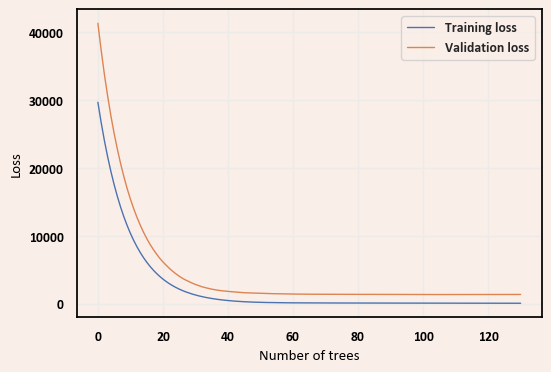

In [63]:
results = xgb_model.evals_result()

plt.figure(figsize=(6,4))
plt.plot(results["validation_0"]["mae"], label="Training loss")
plt.plot(results["validation_1"]["mae"], label="Validation loss")
#plt.axvline(xgb_model.best_ntree_limit, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()
#print(f'No of Optimum Tress = {xgb_model.best_ntree_limit}')

In [64]:
print(f'No of Optimum Tress = {xgb_model.best_ntree_limit}')

No of Optimum Tress = 101


In [65]:
feature_names= X_train.columns.tolist()
xgb_features = pd.DataFrame({'feature_names': feature_names, 
                             'feature_importance': xgb_model.feature_importances_}).sort_values(by=['feature_importance'], ascending=False).reset_index(drop=True)
xgb_features

,feature_names,feature_importance
0,close_rolling_max_24,5.069975e-01
1,close_rolling_max_19,2.401055e-01
2,close_rolling_min_4,5.277326e-02
3,close_rolling_min_5,2.198179e-02
4,close_rolling_max_22,2.188872e-02
...,...,...
125,sin_hour,7.717451e-07
126,close_rolling_max_1,0.000000e+00
127,week_number,0.000000e+00
128,close_rolling_min_1,0.000000e+00


In [66]:
best_features = xgb_features[xgb_features['feature_importance']>=0.01]['feature_names'].tolist()
best_features

['close_rolling_max_24',
 'close_rolling_max_19',
 'close_rolling_min_4',
 'close_rolling_min_5',
 'close_rolling_max_22',
 'close',
 'close_rolling_max_5',
 'close_rolling_min_6',
 'close_rolling_min_21',
 'close_rolling_min_8']

In [67]:
#xgb_features.to_csv('features.csv', index=False) # Storing important features for analyzing

## Check all Best Features

In [68]:
if plot_show_or_not == True:
    sns.heatmap(data[best_features].corr(), annot=True)

In [69]:
#sns.pairplot(data[best_features]) #later

## Hyperparameter Tuning with Optuna

In [70]:
#pip install optuna

In [71]:
import xgboost as xgb
import optuna
from sklearn.metrics import mean_squared_error

def objective(trial):
    # Hyper Parameters
    param = {
        "booster": trial.suggest_categorical("booster", ["gbtree"]),
        "lambda": trial.suggest_int("lambda", 0, 100, step=10),
        "alpha": trial.suggest_int("alpha", 0, 100, step=10),
        "gamma": trial.suggest_float("gamma", 1e-8, 1.0, log=True),
        "subsample": trial.suggest_float("subsample", 0.8, 0.9),
        "min_child_weight": trial.suggest_int("min_child_weight", 2, 10),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.8, 0.9),
        "max_leaves": trial.suggest_int("max_leaves", 1000, 2000,step=20),
        'max_depth': trial.suggest_int('max_depth', 10, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        #"grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    }
    
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        #tree_method = "gpu_hist", # To use GPU
        n_estimators=2000,
        **param
        )
    model.fit(X_train[best_features],y_train,eval_set=[(X_valid[best_features],y_valid)],eval_metric='rmse',early_stopping_rounds=100,verbose=100)
    preds = model.predict(X_valid[best_features])
    error = mean_squared_error(y_valid, preds)
    return error
 
study = optuna.create_study(direction='minimize',study_name="XGB")
study.optimize(objective, n_trials=10) # We can increase n_trials to check more combinations, later increse
 
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2024-02-01 11:14:15,955] A new study created in memory with name: XGB


[0]	validation_0-rmse:33061.52719
[100]	validation_0-rmse:1655.38576
[132]	validation_0-rmse:1657.19776


[I 2024-02-01 11:14:18,923] Trial 0 finished with value: 2698139.2512648525 and parameters: {'booster': 'gbtree', 'lambda': 0, 'alpha': 10, 'gamma': 2.144074785562639e-07, 'subsample': 0.8948059808640301, 'min_child_weight': 4, 'colsample_bytree': 0.8882394244997844, 'max_leaves': 1400, 'max_depth': 13, 'learning_rate': 0.28476877037831205}. Best is trial 0 with value: 2698139.2512648525.


[0]	validation_0-rmse:37653.28944
[100]	validation_0-rmse:1554.74136
[143]	validation_0-rmse:1557.56158


[I 2024-02-01 11:14:22,008] Trial 1 finished with value: 2378475.1281745844 and parameters: {'booster': 'gbtree', 'lambda': 60, 'alpha': 70, 'gamma': 1.5580610975782674e-08, 'subsample': 0.8561204353328343, 'min_child_weight': 7, 'colsample_bytree': 0.8792374994354057, 'max_leaves': 1440, 'max_depth': 14, 'learning_rate': 0.21189335007555998}. Best is trial 1 with value: 2378475.1281745844.


[0]	validation_0-rmse:37222.39714
[100]	validation_0-rmse:1652.70782
[200]	validation_0-rmse:1649.93658
[262]	validation_0-rmse:1652.23568


[I 2024-02-01 11:14:26,582] Trial 2 finished with value: 2715113.6053926554 and parameters: {'booster': 'gbtree', 'lambda': 50, 'alpha': 20, 'gamma': 0.0023019052263733553, 'subsample': 0.840655987103321, 'min_child_weight': 2, 'colsample_bytree': 0.8174623902869784, 'max_leaves': 1160, 'max_depth': 10, 'learning_rate': 0.22259570875581697}. Best is trial 1 with value: 2378475.1281745844.


[0]	validation_0-rmse:43070.17083
[100]	validation_0-rmse:1601.74181
[200]	validation_0-rmse:1577.54540
[283]	validation_0-rmse:1580.95072


[I 2024-02-01 11:14:31,518] Trial 3 finished with value: 2485313.696339939 and parameters: {'booster': 'gbtree', 'lambda': 50, 'alpha': 30, 'gamma': 1.9720121141215675e-07, 'subsample': 0.8669112853930856, 'min_child_weight': 6, 'colsample_bytree': 0.8356267039573918, 'max_leaves': 1320, 'max_depth': 12, 'learning_rate': 0.07017240970727455}. Best is trial 1 with value: 2378475.1281745844.


[0]	validation_0-rmse:45330.09261
[100]	validation_0-rmse:17899.88510
[200]	validation_0-rmse:7665.69538
[300]	validation_0-rmse:3848.26006
[400]	validation_0-rmse:2344.74208
[500]	validation_0-rmse:1792.11262
[600]	validation_0-rmse:1675.40115
[700]	validation_0-rmse:1651.53289
[800]	validation_0-rmse:1637.61258
[900]	validation_0-rmse:1626.70522
[1000]	validation_0-rmse:1623.07921
[1100]	validation_0-rmse:1620.88959
[1200]	validation_0-rmse:1619.73778
[1300]	validation_0-rmse:1619.31311
[1400]	validation_0-rmse:1619.59490
[1427]	validation_0-rmse:1619.82914


[I 2024-02-01 11:14:56,148] Trial 4 finished with value: 2622116.6265184158 and parameters: {'booster': 'gbtree', 'lambda': 10, 'alpha': 40, 'gamma': 2.6994810320517714e-08, 'subsample': 0.8220091642735489, 'min_child_weight': 5, 'colsample_bytree': 0.8870404745929954, 'max_leaves': 1240, 'max_depth': 12, 'learning_rate': 0.010278645162276114}. Best is trial 1 with value: 2378475.1281745844.


[0]	validation_0-rmse:37131.49448
[100]	validation_0-rmse:1586.18308
[152]	validation_0-rmse:1582.66961


[I 2024-02-01 11:14:59,923] Trial 5 finished with value: 2477041.0482526114 and parameters: {'booster': 'gbtree', 'lambda': 10, 'alpha': 90, 'gamma': 6.463864932433338e-07, 'subsample': 0.8635785273484555, 'min_child_weight': 6, 'colsample_bytree': 0.8248684837866769, 'max_leaves': 1920, 'max_depth': 15, 'learning_rate': 0.20412791006671763}. Best is trial 1 with value: 2378475.1281745844.


[0]	validation_0-rmse:41695.66162
[100]	validation_0-rmse:1534.82969
[197]	validation_0-rmse:1538.25846


[I 2024-02-01 11:15:03,324] Trial 6 finished with value: 2343645.5517198313 and parameters: {'booster': 'gbtree', 'lambda': 0, 'alpha': 10, 'gamma': 0.3125534760851885, 'subsample': 0.8272223470907656, 'min_child_weight': 6, 'colsample_bytree': 0.855328950093772, 'max_leaves': 1460, 'max_depth': 10, 'learning_rate': 0.09109745160830526}. Best is trial 6 with value: 2343645.5517198313.


[0]	validation_0-rmse:42605.33912
[100]	validation_0-rmse:1578.76348
[200]	validation_0-rmse:1554.07452
[300]	validation_0-rmse:1555.28266
[356]	validation_0-rmse:1557.29612


[I 2024-02-01 11:15:08,898] Trial 7 finished with value: 2406858.6970404843 and parameters: {'booster': 'gbtree', 'lambda': 90, 'alpha': 60, 'gamma': 0.0014949246931509619, 'subsample': 0.8607782356697878, 'min_child_weight': 6, 'colsample_bytree': 0.833128063762659, 'max_leaves': 1920, 'max_depth': 10, 'learning_rate': 0.08344311277433088}. Best is trial 6 with value: 2343645.5517198313.


[0]	validation_0-rmse:36230.61930
[100]	validation_0-rmse:1535.18662
[144]	validation_0-rmse:1545.95893


[I 2024-02-01 11:15:11,664] Trial 8 finished with value: 2304441.8415431436 and parameters: {'booster': 'gbtree', 'lambda': 100, 'alpha': 90, 'gamma': 0.4424495497653155, 'subsample': 0.8013705797975825, 'min_child_weight': 8, 'colsample_bytree': 0.8706747790963277, 'max_leaves': 1460, 'max_depth': 13, 'learning_rate': 0.2543038754368118}. Best is trial 8 with value: 2304441.8415431436.


[0]	validation_0-rmse:36227.65863
[100]	validation_0-rmse:1544.94672
[131]	validation_0-rmse:1556.61301


[I 2024-02-01 11:15:14,414] Trial 9 finished with value: 2285615.00731641 and parameters: {'booster': 'gbtree', 'lambda': 50, 'alpha': 50, 'gamma': 0.00018981152204101666, 'subsample': 0.8954689203725029, 'min_child_weight': 7, 'colsample_bytree': 0.836460398184344, 'max_leaves': 1180, 'max_depth': 14, 'learning_rate': 0.24794039049777658}. Best is trial 9 with value: 2285615.00731641.


Number of finished trials: 10
Best trial: {'booster': 'gbtree', 'lambda': 50, 'alpha': 50, 'gamma': 0.00018981152204101666, 'subsample': 0.8954689203725029, 'min_child_weight': 7, 'colsample_bytree': 0.836460398184344, 'max_leaves': 1180, 'max_depth': 14, 'learning_rate': 0.24794039049777658}


In [72]:
study.best_params

{'booster': 'gbtree',
 'lambda': 50,
 'alpha': 50,
 'gamma': 0.00018981152204101666,
 'subsample': 0.8954689203725029,
 'min_child_weight': 7,
 'colsample_bytree': 0.836460398184344,
 'max_leaves': 1180,
 'max_depth': 14,
 'learning_rate': 0.24794039049777658}

In [73]:
param = study.best_params
xgbreg = xgb.XGBRegressor(
    objective='reg:squarederror',
    #tree_method = "gpu_hist", # To use GPU
    n_estimators=1000,    
    **param
    )
xgbreg.fit(X_train[best_features],y_train,eval_set=[(X_valid[best_features],y_valid)],eval_metric='rmse',early_stopping_rounds=20,verbose=100)

[0]	validation_0-rmse:36227.65863
[51]	validation_0-rmse:1528.81158


XGBRegressor(alpha=50, base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.836460398184344, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.00018981152204101666, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None, lambda=50,
             learning_rate=0.24794039049777658, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=14, max_leaves=1180,
             min_child_weight=7, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None, ...)

In [74]:
# Making predictions with the tuned model
pred_train = xgbreg.predict(X_train[best_features])
pred_valid = xgbreg.predict(X_valid[best_features])
pred_test = xgbreg.predict(X_test[best_features])

In [75]:
# Evaluate model accuracy 
from sklearn.metrics import mean_squared_error
print(f"Train MSE: {mean_squared_error(y_train['target'],pred_train)}")
print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train['target'],pred_train))}")
print(f"valid MSE: {mean_squared_error(y_valid['target'],pred_valid)}")
print(f"valid RMSE: {np.sqrt(mean_squared_error(y_valid['target'],pred_valid))}")
print(f"Test MSE: {mean_squared_error(y_test['target'],pred_test)}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test['target'],pred_test))}")

Train MSE: 112363.94064463266
Train RMSE: 335.20730995106993
valid MSE: 2285615.00731641
valid RMSE: 1511.8250584364614
Test MSE: 2839943.3716948675
Test RMSE: 1685.2131531930515


In [76]:
result = y[y['datetime'] > test_cutoff].copy()
result[f'prediction_xgb_{stock}'] = pred_test
result.tail(10)

,datetime,target,prediction_xgb_BANKNIFTY
9827,2024-01-29 14:15:00,45395.80,45483.445312
9828,2024-01-29 15:15:00,45319.55,45543.710938
9829,2024-01-30 09:15:00,45824.45,45353.296875
9830,2024-01-30 10:15:00,46056.25,45249.460938
9831,2024-01-30 11:15:00,46046.35,45439.875000
9832,2024-01-30 12:15:00,46015.45,45361.984375
9833,2024-01-30 13:15:00,46041.30,45439.875000
9834,2024-01-30 14:15:00,45990.60,45361.984375
9835,2024-01-30 15:15:00,45974.00,45283.925781
9836,2024-01-31 09:15:00,45855.30,45627.097656


In [77]:
if plot_show_or_not == True:
    
    result_train = y[(y['datetime'] <= validation_cutoff)].copy()
    result_train[f'prediction_xgb_{stock}'] = pred_train
    plt.figure(figsize=(10,5))
    result_train.set_index('datetime').plot()
    plt.title(f"Prediction for TRAIN DATA")

Text(0.5, 1.0, 'Prediction for VALIDATION DATA')

<Figure size 1000x500 with 0 Axes>

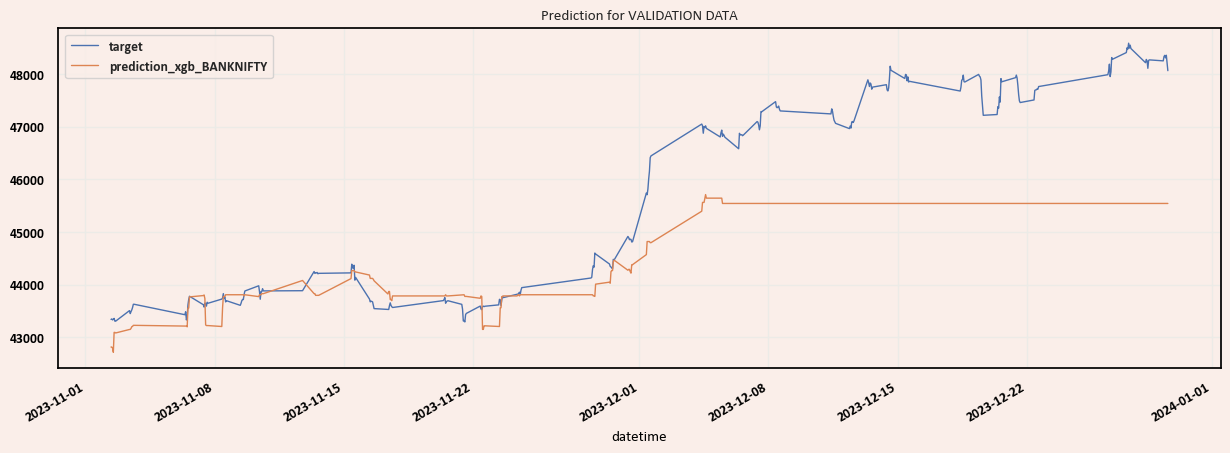

In [78]:
 #We have data from 2020-07-01 00:00:00
 #We have data till 2023-02-13 23:45:00

result_valid = y[(y['datetime'] > validation_cutoff) & (y['datetime'] <= test_cutoff)].copy()
result_valid[f'prediction_xgb_{stock}'] = pred_valid
plt.figure(figsize=(10,5))
result_valid.set_index('datetime').plot()
plt.title(f"Prediction for VALIDATION DATA")

Text(0.5, 1.0, 'Prediction for TEST')

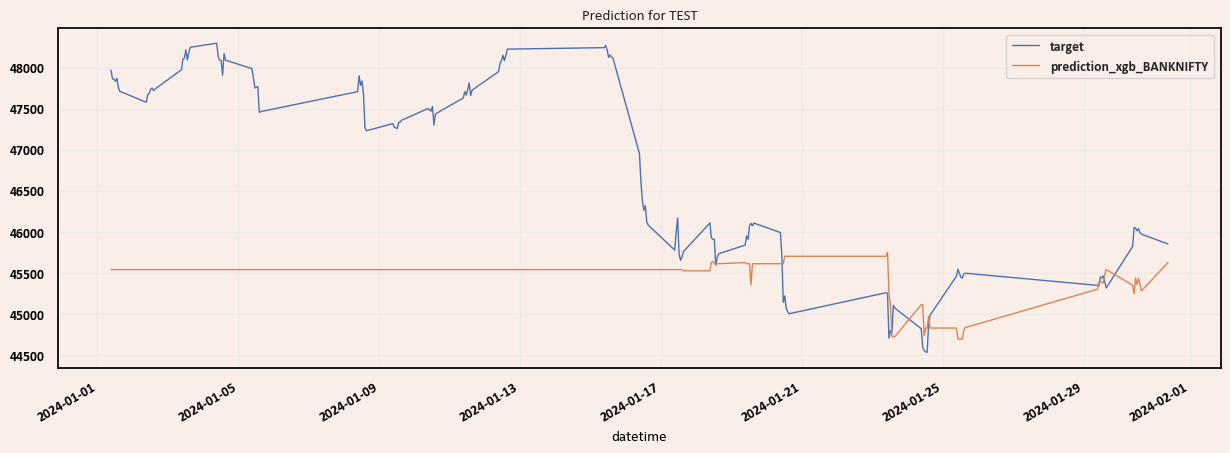

In [79]:

mask = (result.datetime > test_cutoff)
result.loc[mask,:].set_index('datetime')
result.loc[mask,:].set_index('datetime').plot()
plt.title("Prediction for TEST")

#result.loc[mask,:].set_index('datetime')

## Find Last working and Next working DAY

In [80]:
holiday_list = ['2023-11-27', '2023-12-25']
#holiday_list = [x+' 00:00:00' for x in holiday_list]
#holiday_list = [datetime.strptime(x, '%Y-%m-%d') for x in holiday_list]

In [81]:
def check_is_inbetween_market_time(test_date):
    #----This block of code will check if we are running code before 3:30PM then it will not take today's data----
    if test_date not in holiday_list and test_date.weekday() not in [5, 6]:    
        now = datetime.now()
        today15_30 = now.replace(hour=15, minute=30, second=0)
        if now <= today15_30:
            test_date = test_date-timedelta(days=1)
    return test_date

check_is_inbetween_market_time(datetime.now())

datetime.datetime(2024, 1, 31, 11, 15, 18, 351942)

In [82]:
def find_last_working_day(test_date):
    
    if test_date.weekday() == 0:
        diff = 3
    elif test_date.weekday() == 6:
        diff = 2
    else :
        diff = 1

    res = test_date - timedelta(days=diff)
    
    while str(res) in holiday_list:
        res = res - timedelta(days=1)
        
    if res.weekday() in [0, 6]:
        res = find_last_working_day(res) # Recursive call beacuse 
        # may be we have today tuesday and on monday we have holiday
        # then without recursive call it will give sunday as last working day
        
    return res

find_last_working_day(dt.date.today())

datetime.date(2024, 1, 31)

In [83]:
def find_Next_working_day(test_date):
    
    test_date = test_date + timedelta(days=1)
    if test_date.weekday() == 5:
        add = 2
    elif test_date.weekday() == 6:
        add = 1
    else :
        add = 0

    res = test_date + timedelta(days=add)
    
    while str(res) in holiday_list:
        res = res + timedelta(days=1)
        
    if res.weekday() in [5, 6]:
        res = find_Next_working_day(res) # Recursive call
        
    return res

find_Next_working_day(dt.date.today())

datetime.date(2024, 2, 2)

In [84]:
#test_date = datetime(2023, 11, 16)
test_date = dt.date.today()
test_date_as_time = check_is_inbetween_market_time(test_date)

last_working = find_last_working_day(test_date_as_time)
next_working = find_Next_working_day(test_date_as_time)

print(f"Input Date & Time:{datetime.now()} ~~~~ Last Working date:{str(last_working)}")
print(f"Input Date & Time:{datetime.now()} ~~~~ NEXT Working date:{str(next_working)}")

Input Date & Time:2024-02-01 11:15:18.457763 ~~~~ Last Working date:2024-01-30
Input Date & Time:2024-02-01 11:15:18.457763 ~~~~ NEXT Working date:2024-02-01


In [85]:
# result.datetime.to_numpy()[0] > dt.date.today()

In [86]:
#(result.datetime > pd.Timestamp.today())
#result.datetime > np.datetime64('today', 'D')

In [87]:
# ajj = dt.date.today()
# #ajj = np.datetime64('today', 'D')
# end_date = find_last_working_day(ajj)
# np.datetime64(end_date)

## Peformance for LAST working DAY

Forcast for: 2024-02-01
Basicall for today's prediction, Datetime will be yesterday's only as per logic As we have shifted target by 1, so for Date 15th prediction Datetime will show 14th


,target,prediction_xgb_BANKNIFTY
datetime,,
2024-01-30 09:15:00,45824.45,45353.296875
2024-01-30 10:15:00,46056.25,45249.460938
2024-01-30 11:15:00,46046.35,45439.875000
2024-01-30 12:15:00,46015.45,45361.984375
2024-01-30 13:15:00,46041.30,45439.875000
2024-01-30 14:15:00,45990.60,45361.984375
2024-01-30 15:15:00,45974.00,45283.925781
2024-01-31 09:15:00,45855.30,45627.097656


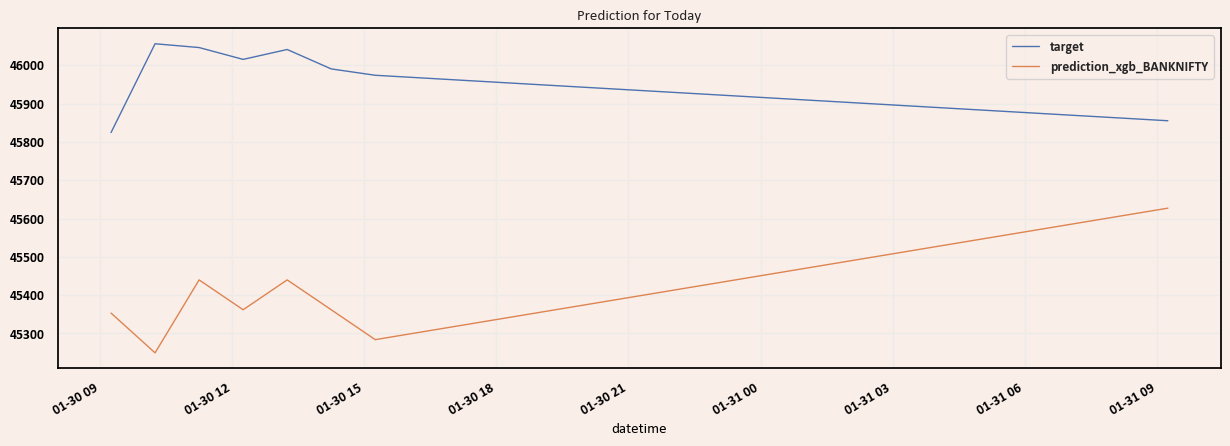

In [88]:
ajj = dt.date.today() # I guess its in python only
#ajj = np.datetime64('today', 'D') # How we define in numpy
#ajj = pd.Timestamp.today()  # How we define in pandas

ajj = check_is_inbetween_market_time(ajj)
end_date = find_last_working_day(ajj)

next_working = find_Next_working_day(ajj)



# #---Below will work for weekdays as well--------------
# #----- to run code for Saturday and Sunday------------------
# if ajj.weekday() == 5:
#     ajj = ajj - timedelta(days=1)
#     end_date = end_date - timedelta(days=1)

# if ajj.weekday() == 6:
#     ajj = ajj - timedelta(days=2)
#     end_date = end_date - timedelta(days=2)
# #----- End of to run code for Saturday and Sunday------------------
    
    
    
    

print(f"Forcast for: {next_working}")
print("Basicall for today's prediction, Datetime will be yesterday's only as per logic As we have shifted target by 1, so for Date 15th prediction Datetime will show 14th")
mask = (result.datetime >= np.datetime64(end_date))
#mask = (result.datetime >= end_date)

result.loc[mask,:].set_index('datetime').plot()
plt.title("Prediction for Today")

result.loc[mask,:].set_index('datetime')

In [89]:
# # JUST ANOTHER WAY FOR ABOVE CODE

# end_date = dt.date.today()
# days_sub = 1 # XXXXXXXXXXXXXXXXXXXXXXX
# end_date = dt.datetime(end_date.year, end_date.month, end_date.day-days_sub, 9, 15)

# print(f"Forcast Date~~~~~{end_date}")

# mask = (result.datetime >= end_date)
# result.loc[mask,:].set_index('datetime').plot()
# plt.title("Prediction for Today")


# result.loc[mask,:].set_index('datetime')

In [90]:
def feature_importance(features, importance_score):
    importances = pd.DataFrame(data={
        'Attribute': features,
        'Importance': importance_score
    })
    importances = importances.sort_values(by='Importance', ascending=False)
    plt.bar(x=importances['Attribute'], height=importances['Importance'])
    plt.title('Feature importances obtained from coefficients')
    plt.xticks(rotation='vertical')
    plt.show()

In [91]:
print(X_train.columns.shape)
print(xgbreg.feature_importances_.shape)

(130,)
(10,)


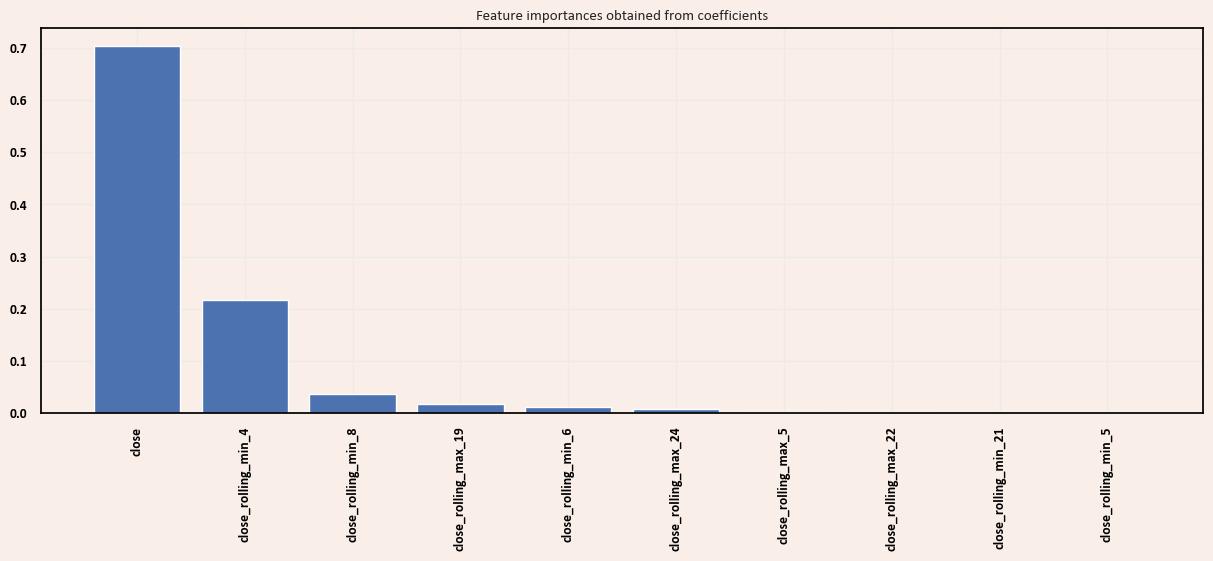

In [92]:
feature_importance(best_features, xgbreg.feature_importances_)

## Final Model saving

In [93]:
# Saving the final Best features used by model
model_name = f"{stock}_best_features_XGBoost"
pickle.dump(best_features, open(f'03_Saved_Model/{model_name}.pkl', 'wb'))

In [94]:
# Saving the final model
model_name = f"{stock}_XGBoost"
pickle.dump(xgbreg, open(f'03_Saved_Model/{model_name}.pkl', 'wb'))

# ********Final Prediction (XGBoost)********

In [95]:
test_date = dt.date.today()

#ibirdi - I have added below line on 01 Feb 2024
test_date = check_is_inbetween_market_time(test_date)
#ibirdi - end of I have added below line on 01 Feb 2024


next_working = find_Next_working_day(test_date)
next_working = dt.datetime(next_working.year, next_working.month, next_working.day, 9, 15)
next_working

datetime.datetime(2024, 2, 1, 9, 15)

In [96]:
pred_day_ahead = pd.DataFrame(pd.date_range(start=next_working, periods=target_ahead_timeblocks, freq=frequency_in_mins), columns=['datetime']) #inclusive in the newer version
pred_day_ahead.set_index("datetime", inplace = True)
pred_day_ahead[f'prediction_xgb_{stock}'] = xgbreg.predict(next_day_df_prediction[best_features])
pred_day_ahead

,prediction_xgb_BANKNIFTY
datetime,
2024-02-01 09:15:00,45590.019531
2024-02-01 10:15:00,45648.671875
2024-02-01 11:15:00,45648.671875
2024-02-01 12:15:00,45710.769531
2024-02-01 13:15:00,45710.769531
2024-02-01 14:15:00,45752.507812
2024-02-01 15:15:00,45752.507812


In [97]:
# pred_day_ahead = pd.DataFrame()
# pred_day_ahead.index = next_day_df_prediction['datetime']
# pred_day_ahead[f'prediction_xgb_{stock}'] = xgbreg.predict(next_day_df_prediction[best_features])
# pred_day_ahead

# Model-2 - Logistic Regression

In [98]:
#We Have the following:
#X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(X, y, validation_cutoff, test_cutoff)

### Multicollinearity check by VIF score

In [99]:
# """
# Let's now keep on removing features till we have a feature with vif<5
# """
# import statsmodels.api as sm

# scaler_vif = StandardScaler()
# X_train_vif_s = scaler_vif.fit_transform(X_train)





# vif_thr = 20
# #r2_thr = 0.85
# i = 0
# feats_removed = []

# cols2=X.columns

# while True:
    
#     vif = pd.DataFrame()
#     X_t = pd.DataFrame(X_train_vif_s, columns=X.columns)[cols2]
#     vif['Features'] = cols2
#     vif['VIF'] = [variance_inflation_factor(X_t.values, i) for i in range(X_t.shape[1])]
#     vif['VIF'] = round(vif['VIF'], 2)
#     vif = vif.sort_values(by = "VIF", ascending = False)

#   #cols2 = vif["Features"][1:].values
#     cols2 = vif["Features"][i:].values
#     X2 = pd.DataFrame(X_train_vif_s, columns=X.columns)[cols2]

#     #X2_sm = sm.add_constant(X2)  #Statmodels default is without intercept, to add intercept we need to add constant
#     #sm_model = sm.OLS(list(y_train), X2_sm).fit()
  
#     print('Feature no. ', i)
#     print('VIF Score ', vif.iloc[i]['VIF'])
#     #print('Adjusted R2 ', sm_model.rsquared_adj)


#     #if (vif.iloc[i]['VIF'] < vif_thr) or (sm_model.rsquared_adj > r2_thr):
#     if (vif.iloc[i]['VIF'] < vif_thr):
#         print('Reached threshold')
#         print('Highest vif:',vif.iloc[i])
#         #print('Current adj.R2',sm_model.rsquared_adj)
#         print('Features removed:', i)
#         print('List of features removed:', feats_removed)
#         break
#     feats_removed.append(vif.iloc[i]['Features'])
#     i += 1

In [100]:
X_train

,close,hour,dom,month,dow,doy,woy,week_number,friday,covid,...,close_rolling_max_28,close_rolling_min_28,close_rolling_mean_29,close_rolling_max_29,close_rolling_min_29,ramp1,ramp2,ramp3,ramp4,ramp_close
0,25781.05,10,23,5,2,143,21,21,0.0,0.0,...,26167.25,25711.70,25897.068966,26182.15,25711.70,3.35,11.15,-80.60,44.25,-79.40
1,25818.20,11,23,5,2,143,21,21,0.0,0.0,...,26139.20,25711.70,25883.237931,26167.25,25711.70,37.15,3.35,11.15,-80.60,83.10
2,25884.05,12,23,5,2,143,21,21,0.0,0.0,...,26139.20,25711.70,25871.201724,26139.20,25711.70,65.85,37.15,3.35,11.15,128.75
3,25866.30,13,23,5,2,143,21,21,0.0,0.0,...,26139.20,25711.70,25862.587931,26139.20,25711.70,-17.75,65.85,37.15,3.35,63.40
4,25829.80,14,23,5,2,143,21,21,0.0,0.0,...,26073.80,25711.70,25855.294828,26139.20,25711.70,-36.50,-17.75,65.85,37.15,-17.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9410,42733.25,12,1,11,2,305,44,44,0.0,0.0,...,43073.60,42144.20,42711.493103,43073.60,42144.20,66.30,-41.65,-119.15,-15.85,-176.20
9411,42652.25,13,1,11,2,305,44,44,0.0,0.0,...,43073.60,42272.60,42729.463793,43073.60,42144.20,-81.00,66.30,-41.65,-119.15,-352.60
9412,42669.10,14,1,11,2,305,44,44,0.0,0.0,...,43073.60,42272.60,42746.982759,43073.60,42272.60,16.85,-81.00,66.30,-41.65,-324.00
9413,42705.25,15,1,11,2,305,44,44,0.0,0.0,...,43073.60,42288.15,42760.613793,43073.60,42272.60,36.15,16.85,-81.00,66.30,-138.35


In [101]:
11638-(11056+441+141)

0

## Scaling

In [102]:
print(X_train.columns.tolist())

['close', 'hour', 'dom', 'month', 'dow', 'doy', 'woy', 'week_number', 'friday', 'covid', 'covid_first_wave', 'covid_second_wave', 'cos_hour', 'sin_hour', 'cos_dow', 'sin_dow', 'cos_doy', 'sin_doy', 'lag1h', 'lag2h', 'lag4h', 'lag6h', 'lag12h', 'lag1d', 'lag2d', 'lag3d', 'lag4d', 'lag5d', 'lag6d', 'lag7d', 'mcp_dam_ewm1h', 'mcp_dam_ewm2h', 'mcp_dam_ewm3h', 'mcp_dam_ewm4h', 'mcp_dam_ewm6h', 'mcp_dam_ewm8h', 'mcp_dam_ewm12h', 'mcp_dam_ewm24h', 'close_rolling_mean_1', 'close_rolling_max_1', 'close_rolling_min_1', 'close_rolling_mean_2', 'close_rolling_max_2', 'close_rolling_min_2', 'close_rolling_mean_3', 'close_rolling_max_3', 'close_rolling_min_3', 'close_rolling_mean_4', 'close_rolling_max_4', 'close_rolling_min_4', 'close_rolling_mean_5', 'close_rolling_max_5', 'close_rolling_min_5', 'close_rolling_mean_6', 'close_rolling_max_6', 'close_rolling_min_6', 'close_rolling_mean_7', 'close_rolling_max_7', 'close_rolling_min_7', 'close_rolling_mean_8', 'close_rolling_max_8', 'close_rolling_min

In [103]:
len(X_train.columns)

130

In [104]:
# rescale the features
#scaler = MinMaxScaler()
scaler = StandardScaler()
#scaler = RobustScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid) # Transform to Validation data as well
X_test_scaled = scaler.transform(X_test) # Transform to test data as well

In [105]:
print('Train =', X_train_scaled.shape, y_train.shape)
print('Train =', X_valid_scaled.shape, y_valid.shape)
print('Test =', X_test_scaled.shape, y_test.shape)

Train = (9415, 130) (9415, 1)
Train = (274, 130) (274, 1)
Test = (148, 130) (148, 1)


In [106]:
X_train.columns

Index(['close', 'hour', 'dom', 'month', 'dow', 'doy', 'woy', 'week_number',
       'friday', 'covid',
       ...
       'close_rolling_max_28', 'close_rolling_min_28', 'close_rolling_mean_29',
       'close_rolling_max_29', 'close_rolling_min_29', 'ramp1', 'ramp2',
       'ramp3', 'ramp4', 'ramp_close'],
      dtype='object', length=130)

In [107]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

reg_model = LinearRegression(n_jobs=-1)
reg_model.fit(X_train_scaled, y_train)

# Make predictions using the testing set
y_train_pred = reg_model.predict(X_train_scaled)
X_valid_pred = reg_model.predict(X_valid_scaled)
y_test_pred = reg_model.predict(X_test_scaled)


In [108]:
# Making predictions with the tuned model
pred_train = reg_model.predict(X_train_scaled)
pred_valid = reg_model.predict(X_valid_scaled)
pred_test = reg_model.predict(X_test_scaled)

In [109]:
# Evaluate model accuracy 
from sklearn.metrics import mean_squared_error
print(f"Train MSE: {mean_squared_error(y_train['target'],pred_train)}")
print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train['target'],pred_train))}")
print(f"valid MSE: {mean_squared_error(y_valid['target'],pred_valid)}")
print(f"valid RMSE: {np.sqrt(mean_squared_error(y_valid['target'],pred_valid))}")
print(f"Test MSE: {mean_squared_error(y_test['target'],pred_test)}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test['target'],pred_test))}")

Train MSE: 204721.18605335648
Train RMSE: 452.4612536487036
valid MSE: 159757.02800860387
valid RMSE: 399.6961696196298
Test MSE: 313749.05841939215
Test RMSE: 560.1330720635875


In [110]:
#result = y[y['datetime'] > test_cutoff].copy()
result[f'prediction_LR_{stock}'] = pred_test
result.tail(10)

,datetime,target,prediction_xgb_BANKNIFTY,prediction_LR_BANKNIFTY
9827,2024-01-29 14:15:00,45395.80,45483.445312,45335.436157
9828,2024-01-29 15:15:00,45319.55,45543.710938,45410.364338
9829,2024-01-30 09:15:00,45824.45,45353.296875,45150.089938
9830,2024-01-30 10:15:00,46056.25,45249.460938,45175.050768
9831,2024-01-30 11:15:00,46046.35,45439.875000,45231.768105
9832,2024-01-30 12:15:00,46015.45,45361.984375,45210.624077
9833,2024-01-30 13:15:00,46041.30,45439.875000,45240.329706
9834,2024-01-30 14:15:00,45990.60,45361.984375,45201.219197
9835,2024-01-30 15:15:00,45974.00,45283.925781,45172.300927
9836,2024-01-31 09:15:00,45855.30,45627.097656,45674.673782


In [111]:
if plot_show_or_not == True:
    
    result_train = y[(y['datetime'] <= validation_cutoff)].copy()
    result_train[f'prediction_LR_{stock}'] = pred_train
    plt.figure(figsize=(10,5))
    result_train.set_index('datetime').plot()
    plt.title(f"Prediction for TRAIN DATA")

Text(0.5, 1.0, 'Prediction for VALIDATION DATA')

<Figure size 1000x500 with 0 Axes>

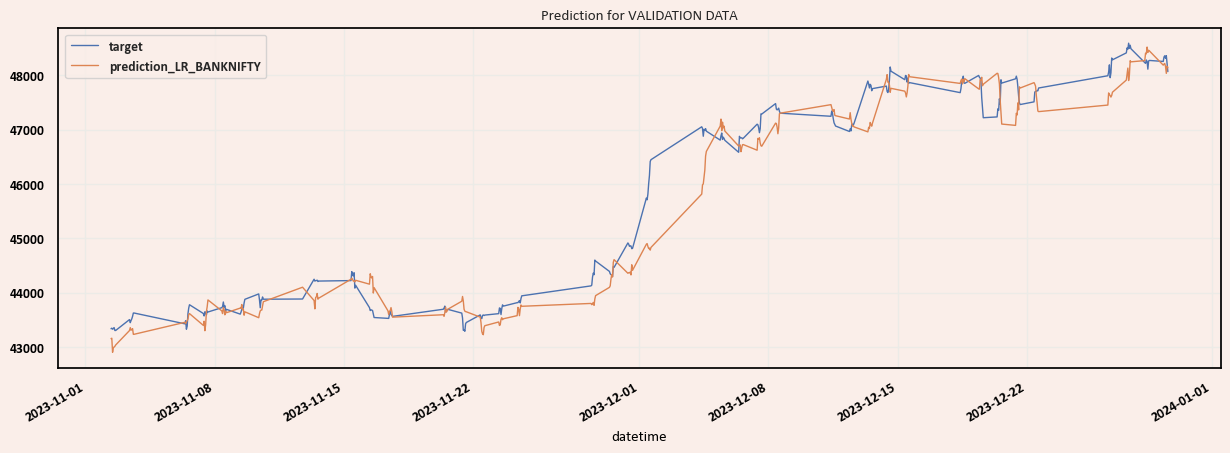

In [112]:
result_valid = y[(y['datetime'] > validation_cutoff) & (y['datetime'] <= test_cutoff)].copy()
result_valid[f'prediction_LR_{stock}'] = pred_valid
plt.figure(figsize=(10,5))
result_valid.set_index('datetime').plot()
plt.title(f"Prediction for VALIDATION DATA")

Text(0.5, 1.0, 'Prediction for TEST')

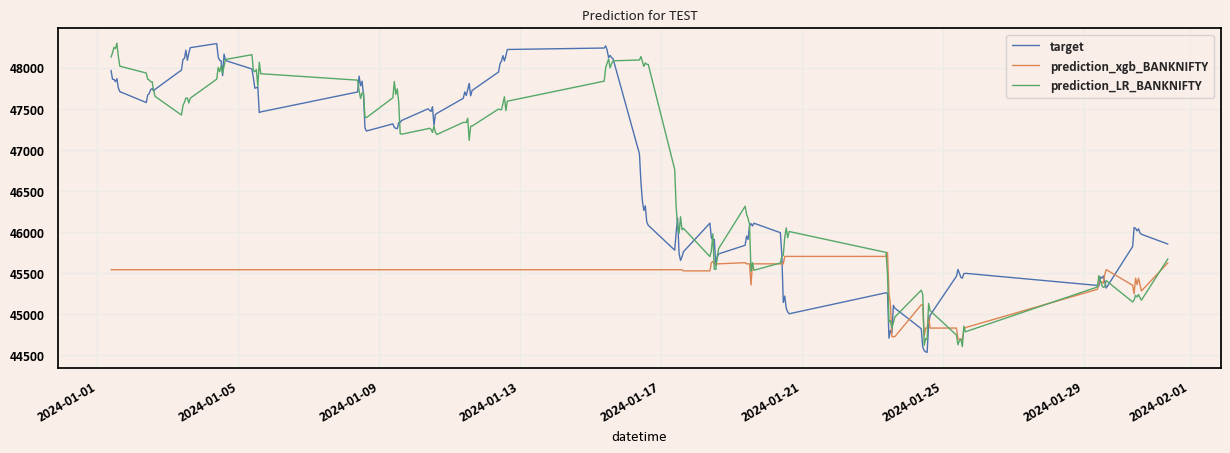

In [113]:
mask = (result.datetime > test_cutoff)
result.loc[mask,:].set_index('datetime')
result.loc[mask,:].set_index('datetime').plot()
plt.title("Prediction for TEST")

Forcast for: 2024-01-31
Basicall for today's prediction, Datetime will be yesterday's only as per logic As we have shifted target by 1, so for Date 15th prediction Datetime will show 14th


,target,prediction_xgb_BANKNIFTY,prediction_LR_BANKNIFTY
datetime,,,
2024-01-30 09:15:00,45824.45,45353.296875,45150.089938
2024-01-30 10:15:00,46056.25,45249.460938,45175.050768
2024-01-30 11:15:00,46046.35,45439.875000,45231.768105
2024-01-30 12:15:00,46015.45,45361.984375,45210.624077
2024-01-30 13:15:00,46041.30,45439.875000,45240.329706
2024-01-30 14:15:00,45990.60,45361.984375,45201.219197
2024-01-30 15:15:00,45974.00,45283.925781,45172.300927
2024-01-31 09:15:00,45855.30,45627.097656,45674.673782


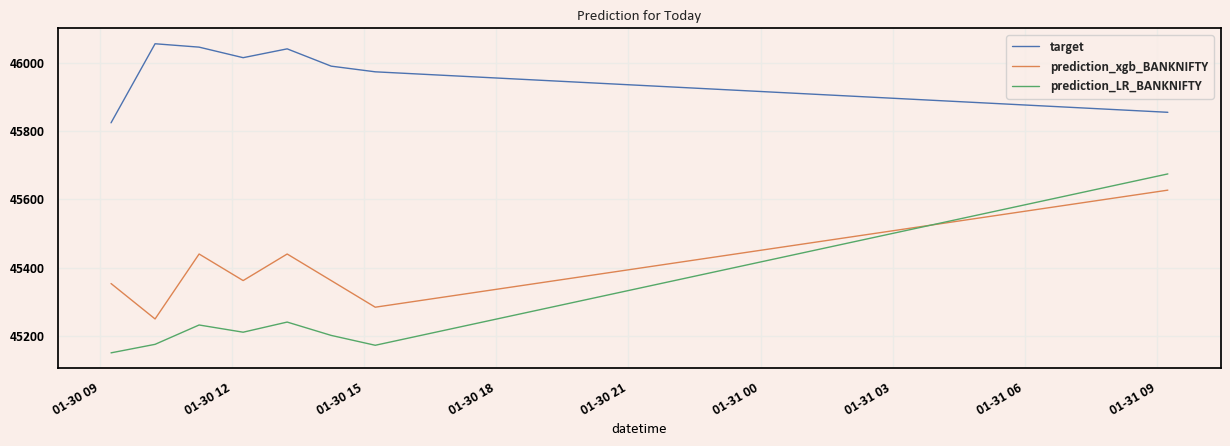

In [114]:
print(f"Forcast for: {ajj}")
print("Basicall for today's prediction, Datetime will be yesterday's only as per logic As we have shifted target by 1, so for Date 15th prediction Datetime will show 14th")

mask = (result.datetime > np.datetime64(end_date))
#mask = (result.datetime >= end_date)

result.loc[mask,:].set_index('datetime').plot()
plt.title("Prediction for Today")

final_prediction_df = result.loc[mask,:].set_index('datetime').copy()
final_prediction_df

## Feature Importance checking

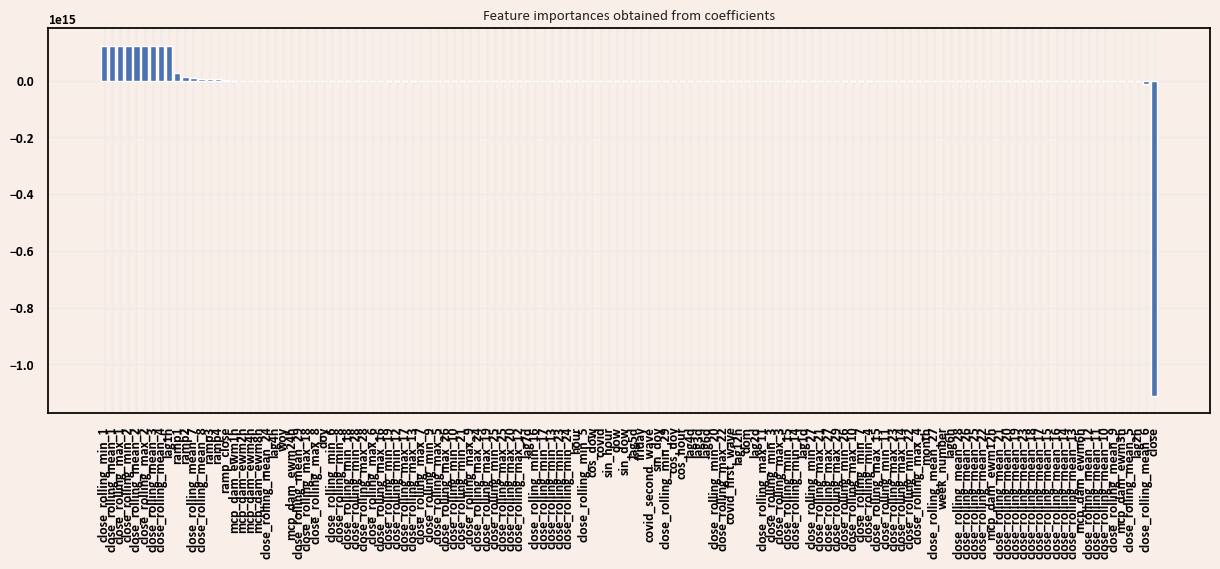

In [115]:
feature_importance(X_train.columns, reg_model.coef_[0])

## Final Model saving

In [116]:
# Saving the final scaler model
model_name = f"{stock}_scaler_LR"
pickle.dump(scaler, open(f'03_Saved_Model/{model_name}.pkl', 'wb'))

In [117]:
# Saving the final model
model_name = f"{stock}_LR"
pickle.dump(reg_model, open(f'03_Saved_Model/{model_name}.pkl', 'wb'))

In [118]:
# Checking Current day Prediction of stock along with name
# Keep it mind that this is not final prediction for next day

final_prediction_df.insert(0,'Stock', stock)  # This is code to add column at specific location
final_prediction_df

,Stock,target,prediction_xgb_BANKNIFTY,prediction_LR_BANKNIFTY
datetime,,,,
2024-01-30 09:15:00,BANKNIFTY,45824.45,45353.296875,45150.089938
2024-01-30 10:15:00,BANKNIFTY,46056.25,45249.460938,45175.050768
2024-01-30 11:15:00,BANKNIFTY,46046.35,45439.875000,45231.768105
2024-01-30 12:15:00,BANKNIFTY,46015.45,45361.984375,45210.624077
2024-01-30 13:15:00,BANKNIFTY,46041.30,45439.875000,45240.329706
2024-01-30 14:15:00,BANKNIFTY,45990.60,45361.984375,45201.219197
2024-01-30 15:15:00,BANKNIFTY,45974.00,45283.925781,45172.300927
2024-01-31 09:15:00,BANKNIFTY,45855.30,45627.097656,45674.673782


# ********Final Prediction (Linear Regression)********

In [119]:
tobe_used_features = get_final_features(next_day_df_prediction)
tobe_used_features.remove('datetime') # Remove DateTime as well as we dont need it
print(len(tobe_used_features))

130


In [120]:
next_day_df_prediction_LR = next_day_df_prediction[tobe_used_features]
#print(next_day_df_prediction_LR.columns.tolist())

next_day_df_prediction_LR_scaled = scaler.transform(next_day_df_prediction_LR) # Scaled the DF

pred_day_ahead[f'prediction_LR_{stock}'] = reg_model.predict(next_day_df_prediction_LR_scaled)
pred_day_ahead

,prediction_xgb_BANKNIFTY,prediction_LR_BANKNIFTY
datetime,,
2024-02-01 09:15:00,45590.019531,45973.082881
2024-02-01 10:15:00,45648.671875,46037.457112
2024-02-01 11:15:00,45648.671875,45964.037922
2024-02-01 12:15:00,45710.769531,46024.520834
2024-02-01 13:15:00,45710.769531,46030.640057
2024-02-01 14:15:00,45752.507812,46043.858066
2024-02-01 15:15:00,45752.507812,45839.386231


In [121]:
final_prediction_df_excel = pred_day_ahead.copy()

In [122]:
import xlwings as xw

df_date_check = final_prediction_df_excel.index[0]

wb = xw.Book('AngelOne_Option.xlsx')
exl_ML_prediction = wb.sheets['ML_prediction']


a = exl_ML_prediction[11,2].value
print(a, "###", final_prediction_df_excel.index[0])
if a == final_prediction_df_excel.index[0]:  # we check if dates are already there and 
                                             # if they are for correct forecasrt day else delete them
    print("Data Appended")
    for c in range(2,300):
        check_blank = exl_ML_prediction[10,c].value
        if check_blank is None:
            exl_ML_prediction[10,c].options(pd.DataFrame, header=1, index=False, expand='table').value = final_prediction_df_excel
            break          
else:
    print("Brand New Data")
    exl_ML_prediction.range("B10:HQ200").clear_contents()
    exl_ML_prediction["C11"].options(pd.DataFrame, header=1, index=True, expand='table').value = final_prediction_df_excel
    
    

2024-02-01 09:15:00 ### 2024-02-01 09:15:00
Data Appended


In [123]:
print("All done and push a little more for more accuracy")

All done and push a little more for more accuracy
